<a href="https://colab.research.google.com/github/Sjoneon/Bigdata2/blob/main/LastRealBigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#
# 셀 1: 환경 설정 및 라이브러리 설치
#
!pip install geopandas lightgbm

from google.colab import drive
drive.mount('/content/drive')

# 한글 시각화를 위한 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("="*50)
print("✅ 라이브러리 설치 및 폰트 설정이 완료되었습니다.")
print("‼️ 중요: Colab 메뉴에서 [런타임] > [세션 다시 시작]을 눌러주세요.")
print("="*50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skippin

In [1]:
#
# 셀 2: 라이브러리 임포트 및 기본 설정
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import glob

# 기본 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option('display.max_columns', None)

print("✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.")

✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.


In [2]:
#
# 셀 3: 종합 데이터 로드
#

# --- 파일 경로 설정 ---
base_path = '/content/drive/My Drive/colab_data/'
# --- 설정 끝 ---

# 파일을 안전하게 로드하는 함수
def load_csv_robust(file_path):
    try:
        return pd.read_csv(file_path, encoding='cp949')
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding='utf-8')
    except Exception as e:
        print(f"오류: {file_path} 파일 로드 실패 - {e}")
        return None

# 데이터 로드
print("--- 데이터 로드 시작 ---")
df_store = load_csv_robust(base_path + '소상공인시장진흥공단_상가(상권)정보_서울_202503.csv')
df_realty = load_csv_robust(base_path + '서울시 부동산 실거래가 정보.csv')
df_sanggwon_pop = load_csv_robust(base_path + '서울시 상권분석서비스(길단위인구-상권).csv')
df_sanggwon_resident = load_csv_robust(base_path + '서울시 상권분석서비스(상주인구-상권).csv')
print("--- 모든 데이터 로드 완료 ---")

--- 데이터 로드 시작 ---
--- 모든 데이터 로드 완료 ---


In [22]:
#
# 셀 4A (파일 탐색): 업로드한 지도 파일 내용 확인
#

# --- 사용자 설정 ---
# 구글 드라이브에 업로드한 정확한 파일 이름을 확장자까지 입력해주세요.
map_filename = "HangJeongDong_ver20250401.geojson"
# -------------------

try:
    map_file_path = base_path + map_filename
    # geopandas는 geojson, shp 등 다양한 공간 파일을 읽을 수 있습니다.
    gdf_map = gpd.read_file(map_file_path, encoding='utf-8')
    print("--- ✅ 파일 로드 성공! (utf-8 인코딩) ---")
except Exception:
    try:
        # utf-8 실패 시, 한글이 포함된 경우를 대비해 euc-kr(cp949)로 재시도
        gdf_map = gpd.read_file(map_file_path, encoding='euc-kr')
        print("--- ✅ 파일 로드 성공! (euc-kr 인코딩) ---")
    except Exception as e:
        print(f"❌ 파일 로드에 실패했습니다: {e}")
        print(f"‼️ 파일 이름 '{map_filename}'과 경로 '{base_path}'가 올바른지 확인해주세요.")
        gdf_map = None

if gdf_map is not None:
    print("\n[파일의 컬럼 목록]")
    print(gdf_map.columns)

    print("\n[데이터 미리보기 (상위 5줄)]")
    # 모든 컬럼을 보기 위해 display 함수를 사용합니다.
    display(gdf_map.head())

--- ✅ 파일 로드 성공! (utf-8 인코딩) ---

[파일의 컬럼 목록]
Index(['adm_nm', 'adm_cd2', 'sgg', 'sido', 'sidonm', 'sggnm', 'adm_cd',
       'geometry'],
      dtype='object')

[데이터 미리보기 (상위 5줄)]


,adm_nm,adm_cd2,sgg,sido,sidonm,sggnm,adm_cd,geometry
0,서울특별시 종로구 사직동,1111053000,11110,11,서울특별시,종로구,11010530,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,서울특별시 종로구 삼청동,1111054000,11110,11,서울특별시,종로구,11010540,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."
2,서울특별시 종로구 부암동,1111055000,11110,11,서울특별시,종로구,11010550,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ..."
3,서울특별시 종로구 평창동,1111056000,11110,11,서울특별시,종로구,11010560,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ..."
4,서울특별시 종로구 무악동,1111057000,11110,11,서울특별시,종로구,11010570,"MULTIPOLYGON (((126.96067 37.5808, 126.96281 3..."


In [4]:
#
# 셀 4 (최종 완성본): 데이터 표준화 및 최종 데이터셋 구축
#
print("--- 데이터 준비 시작: 모든 과정을 이 셀에서 처리합니다 ---")

# --- 1단계: 지도 파일 로드 및 컬럼 이름 표준화 ---
print("\n[1/4] 지도 파일 로드 및 컬럼 이름 표준화...")
map_filename = "HangJeongDong_ver20250401.geojson"
map_file_path = base_path + map_filename
try:
    gdf_map = gpd.read_file(map_file_path, encoding='utf-8')
    print("✅ 지도 파일 로드 성공")
except Exception as e:
    gdf_map = None

if gdf_map is not None:
    # 지도 파일의 실제 컬럼 이름('adm_nm', 'sggnm')을 표준 이름으로 변경
    gdf_map.rename(columns={'sggnm': '시군구명'}, inplace=True)
    gdf_map['행정동명'] = gdf_map['adm_nm'].apply(lambda x: x.split(' ')[-1])
    gdf_seoul_map = gdf_map[['행정동명', '시군구명', 'geometry']]

    # --- 2단계: 공간 결합 및 업종 통합 ---
    print("\n[2/4] 공간 결합 및 업종 통합 분류 중...")
    df_store['상권업종중분류명'] = df_store['상권업종중분류명'].str.strip()
    df_store_cleaned = df_store.dropna(subset=['위도', '경도'])
    gdf_stores = gpd.GeoDataFrame(
        df_store_cleaned,
        geometry=gpd.points_from_xy(df_store_cleaned.경도, df_store_cleaned.위도),
        crs="EPSG:4326"
    )
    df_stores_geocoded = gpd.sjoin(gdf_stores, gdf_seoul_map, how="inner", predicate='within')

    category_map = {
        '카페/디저트': ['비알코올', '제과점'], '한식': ['한식', '구내식당·뷔페'],
        '일식/중식/양식': ['서양식', '중식', '일식', '동남아시아', '기타 외국'], '주점/바': ['주점'],
        '패스트푸드/치킨': ['패스트푸드', '치킨전문점', '피자전문점'],
        '생활편의': ['세탁', '이용·미용', '편의점', '약국/한약방'],
        '쇼핑': ['시계·귀금속 소매', '섬유·의복·신발 소매', '식료품 소매', '기타 생활용품 소매', '의약·화장품 소매',
                 '가전·통신 소매', '장식품 소매', '안경·정밀기기 소매', '기타 상품 소매', '중고 상품 소매',
                 '담배 소매', '철물·건설자재 소매', '음료 소매', '애완동물·용품 소매', '식물 소매', '가구 소매'],
        '오락/숙박': ['유원지·오락', '오락용품 소매', '기타 숙박', '일반 숙박', '욕탕·신체관리'],
    }
    def map_category(category):
        for key, values in category_map.items():
            if category in values: return key
        return '기타'
    df_stores_geocoded['통합업종'] = df_stores_geocoded['상권업종중분류명'].apply(map_category)
    print("✅ 업종 통합 완료")

    # --- 3단계: 최종 데이터셋 생성 ---
    print("\n[3/4] 최종 데이터셋 생성 중...")
    # [오류 해결] 공간 결합으로 생성된 정확한 컬럼명 '행정동명_right', '시군구명_right'를 사용합니다.
    store_counts_by_dong = df_stores_geocoded.groupby(['행정동명_right', '시군구명_right', '통합업종']).size()
    df_final = store_counts_by_dong.unstack().fillna(0).astype(int)
    df_final.reset_index(inplace=True)
    # 표준 컬럼명으로 다시 변경
    df_final.rename(columns={'행정동명_right': '행정동명', '시군구명_right': '시군구명'}, inplace=True)
    print("✅ 행정동-업종별 점포 수 집계 완료")

    # --- 4단계: 입력 변수(Feature) 결합 ---
    print("\n[4/4] 입력 변수 결합 중...")
    # 부동산
    if 'df_realty' in locals() and df_realty is not None:
        realty_price = df_realty.groupby('자치구명')['물건금액(만원)'].mean().reset_index(name='평균부동산가(만원)')
        realty_price.rename(columns={'자치구명': '시군구명'}, inplace=True)
        df_final = pd.merge(df_final, realty_price, on='시군구명', how='left')

    # 유동인구 및 상주인구
    def get_gu_from_sanggwon(name, gu_list):
        for gu in gu_list:
            if gu in name: return gu
        return None
    gu_list = df_final['시군구명'].unique().tolist()
    if 'df_sanggwon_pop' in locals() and df_sanggwon_pop is not None:
        df_sanggwon_pop['시군구명'] = df_sanggwon_pop['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, gu_list) if isinstance(x, str) else None)
        sanggwon_pop_agg = df_sanggwon_pop.groupby('시군구명')['총_유동인구_수'].sum().reset_index()
        df_final = pd.merge(df_final, sanggwon_pop_agg, on='시군구명', how='left')

    if 'df_sanggwon_resident' in locals() and df_sanggwon_resident is not None:
        df_sanggwon_resident['시군구명'] = df_sanggwon_resident['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, gu_list) if isinstance(x, str) else None)
        sanggwon_resident_agg = df_sanggwon_resident.groupby('시군구명')['총_상주인구_수'].sum().reset_index()
        df_final = pd.merge(df_final, sanggwon_resident_agg, on='시군구명', how='left')

    df_final.fillna(0, inplace=True)
    if '기타' in df_final.columns: df_final = df_final.drop(columns=['기타'])
    df_final = df_final.set_index('행정동명')

    print("\n--- ✅ 모든 데이터 준비 완료 ---")
    display(df_final.head())
else:
    print("❌ 지도 파일을 찾지 못했거나 로드에 실패하여 분석을 중단합니다.")

--- 데이터 준비 시작: 모든 과정을 이 셀에서 처리합니다 ---

[1/4] 지도 파일 로드 및 컬럼 이름 표준화...
✅ 지도 파일 로드 성공

[2/4] 공간 결합 및 업종 통합 분류 중...
✅ 업종 통합 완료

[3/4] 최종 데이터셋 생성 중...
✅ 행정동-업종별 점포 수 집계 완료

[4/4] 입력 변수 결합 중...

--- ✅ 모든 데이터 준비 완료 ---


,시군구명,생활편의,쇼핑,오락/숙박,일식/중식/양식,주점/바,카페/디저트,한식,평균부동산가(만원),총_유동인구_수,총_상주인구_수
행정동명,,,,,,,,,,,
가락1동,송파구,38,115,6,16,6,29,87,137139.677980,0.0,0.0
가락2동,송파구,126,196,66,28,25,56,105,137139.677980,0.0,0.0
가락본동,송파구,89,252,203,90,128,80,251,137139.677980,0.0,0.0
가리봉동,구로구,46,109,133,52,51,8,57,50840.769382,24280659.0,133770.0
가산동,금천구,135,1145,253,220,98,305,585,40160.905858,24600544.0,92818.0


In [6]:
#
# 셀 4.5 (디버깅용): 실제 업종 이름 확인
#

print("--- 실제 데이터에 포함된 '상권업종중분류명' 목록 ---")
# 실제 데이터에 어떤 업종 이름들이 있는지 모두 출력합니다.
unique_categories = df_stores_geocoded['상권업종중분류명'].unique()
print(unique_categories)


print("\n\n--- 우리가 만든 '통합업종' 분류 결과 ---")
# 우리가 만든 카테고리별로 몇 개의 점포가 분류되었는지 확인합니다.
# 여기서 '카페/디저트'가 없거나 수치가 0으로 나오면, 이름이 일치하지 않은 것입니다.
print(df_stores_geocoded['통합업종'].value_counts())

--- 실제 데이터에 포함된 '상권업종중분류명' 목록 ---
['비알코올 ' '부동산 서비스' '한식' '시계·귀금속 소매' '섬유·의복·신발 소매' '식료품 소매' '기타 생활용품 소매'
 '이용·미용' '기타 가정용품 수리' '인쇄·제품제작' '의약·화장품 소매' '세탁' '유원지·오락' '가전·통신 소매'
 '장식품 소매' '기타 간이' '주점' '종합 소매' '기타 사업 서비스' '가전제품 수리' '전문 디자인' '청소·방제'
 '기술 서비스' '안경·정밀기기 소매' '광고' '서양식' '사진 촬영' '자동차 수리·세차' '중식' '컴퓨터 수리'
 '기타 전문 과학' '오락용품 소매' '산업용품 대여' '기타 상품 소매' '여행사·보조' '중고 상품 소매' '스포츠 서비스'
 '기타 교육' '회계·세무' '법무관련 ' '담배 소매' '본사·경영 컨설팅' '교육 지원' '철물·건설자재 소매' '일식'
 '사무 지원' '통신장비 수리' '가정용품 대여' '음료 소매' '고용 알선' '모터사이클 소매' '기타 숙박' '일반 숙박'
 '욕탕·신체관리' '동남아시아' '구내식당·뷔페' '애완동물·용품 소매' '시설관리' '기타 보건' '수의' '식물 소매'
 '기타 개인' '연료 소매' '도서관·사적지' '일반 교육' '운송장비 대여' '가구 소매' '모터사이클 수리' '의원' '병원'
 '자동차 부품 소매' '시장 조사' '장례식장 ' '조경·유지' '기타 외국']


--- 우리가 만든 '통합업종' 분류 결과 ---
통합업종
기타    538942
Name: count, dtype: int64


--- 핵심 지표별 상관관계 분석 (행정동 단위) ---


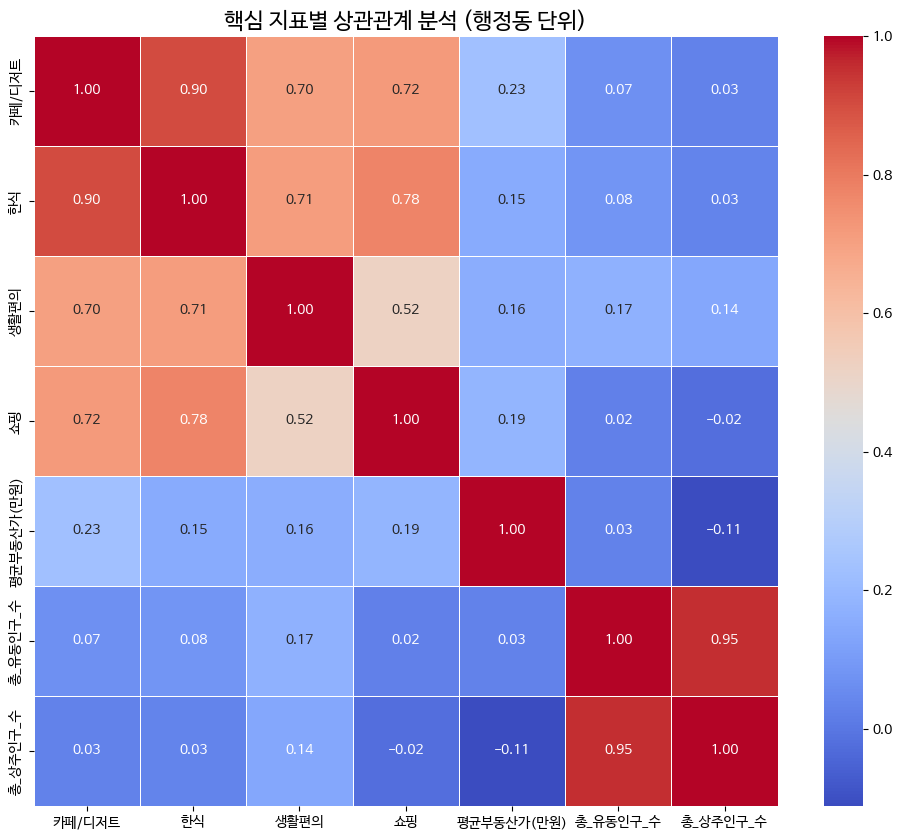


--- '카페/디저트' 점포수 분포 분석 ---


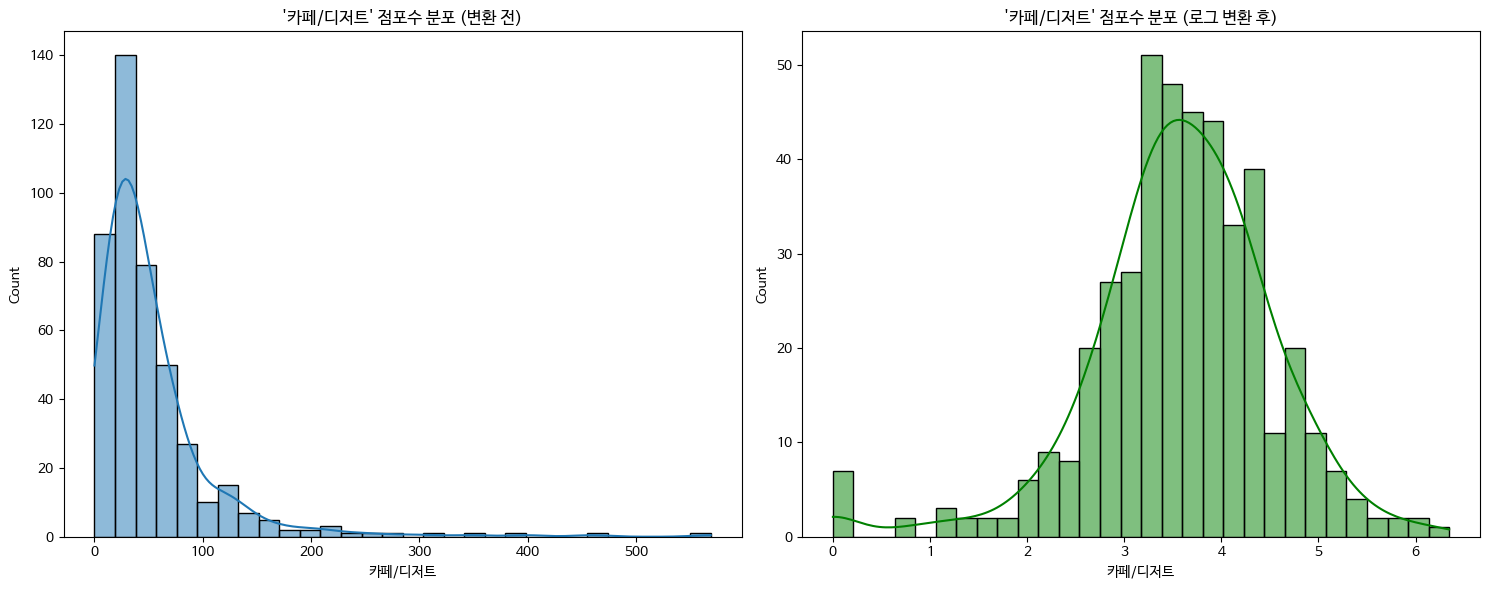

분석: 점포수 분포가 오른쪽으로 치우쳐 있으므로, 로그 변환을 사용하면 모델 성능이 향상될 수 있습니다.


In [6]:
#
# 셀 5: 데이터 탐색 (상관관계 및 분포 확인)
#

# 1. 분석에 사용할 최종 변수들만 선택
# df_final에 업종 컬럼이 많이 있으므로, 일부 핵심 업종과 입력 변수만 선택하여 히트맵을 그립니다.
heatmap_cols = ['카페/디저트', '한식', '생활편의', '쇼핑', '평균부동산가(만원)', '총_유동인구_수', '총_상주인구_수']
# df_final에 없는 컬럼은 오류 방지를 위해 제외
heatmap_cols = [col for col in heatmap_cols if col in df_final.columns]
df_corr = df_final[heatmap_cols]

# 2. 상관관계 히트맵
print("--- 핵심 지표별 상관관계 분석 (행정동 단위) ---")
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('핵심 지표별 상관관계 분석 (행정동 단위)', fontsize=16)
plt.show()

# 3. 주요 목표 변수('카페/디저트')의 분포 확인
print("\n--- '카페/디저트' 점포수 분포 분석 ---")
target_category_check = '카페/디저트'
if target_category_check in df_final.columns:
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_final[target_category_check], kde=True, bins=30)
    plt.title(f"'{target_category_check}' 점포수 분포 (변환 전)")

    # 로그 변환 후 분포도 함께 확인
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df_final[target_category_check]), kde=True, color='green', bins=30)
    plt.title(f"'{target_category_check}' 점포수 분포 (로그 변환 후)")
    plt.tight_layout()
    plt.show()
    print("분석: 점포수 분포가 오른쪽으로 치우쳐 있으므로, 로그 변환을 사용하면 모델 성능이 향상될 수 있습니다.")
else:
    print(f"'{target_category_check}' 업종이 데이터에 없어 분포를 확인할 수 없습니다.")

In [12]:
#
# 셀 6 (수정): 모델링 준비 (스케일링만 수행)
#
from sklearn.preprocessing import StandardScaler

# 1. 모델의 입력 변수(X) 정의
# PCA를 사용하지 않고, 원래의 변수들을 그대로 사용합니다.
features = ['평균부동산가(만원)', '총_유동인구_수', '총_상주인구_수']
features = [f for f in features if f in df_final.columns]
X_features = df_final[features]

# 2. 데이터 스케일링 (선형 회귀 성능 향상에 도움)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
print("✅ 입력 변수 스케일링 완료")

# 3. 목표 변수 로그 변환
target_categories = ['카페/디저트', '한식', '패스트푸드/치킨', '생활편의', '쇼핑', '주점/바']
target_categories = [col for col in target_categories if col in df_final.columns]

df_final_log = pd.DataFrame(index=df_final.index)
for col in target_categories:
    df_final_log[f'로그_{col}'] = np.log1p(df_final[col])

print("✅ 모델링을 위한 모든 데이터 준비 완료")

✅ 입력 변수 스케일링 완료
✅ 모델링을 위한 모든 데이터 준비 완료


--- 업종별 선형회귀 분석 시작 ---
  -> [카페/디저트] 모델 설명력(R²): -3.28%
  -> [한식] 모델 설명력(R²): -8.75%
  -> [생활편의] 모델 설명력(R²): -5.60%
  -> [쇼핑] 모델 설명력(R²): -5.31%
  -> [주점/바] 모델 설명력(R²): -12.14%

--- ✅ 업종별 분석 및 최종 요약 테이블 완성 ---


,카페/디저트_실제,카페/디저트_적정,한식_실제,한식_적정,생활편의_실제,생활편의_적정,쇼핑_실제,쇼핑_적정,주점/바_실제,주점/바_적정
행정동명,,,,,,,,,,
가락1동,29,41,87,82,38,61,115,153,6,21
가락2동,56,41,105,82,126,61,196,153,25,21
가락본동,80,41,251,82,89,61,252,153,128,21
가리봉동,8,30,57,67,46,55,109,103,51,20
가산동,305,25,585,61,135,47,1145,91,98,18



--- 업종별 핵심 요인 영향력(계수) 비교 ---
(양수일수록 점포 수 증가에, 음수일수록 감소에 영향을 줌)


,카페/디저트_영향력,한식_영향력,생활편의_영향력,쇼핑_영향력,주점/바_영향력
평균부동산가(만원),0.311688,0.208317,0.222632,0.332799,0.114857
총_유동인구_수,-0.185456,-0.038278,-0.195339,-0.126328,-0.087903
총_상주인구_수,0.276013,0.158204,0.356387,0.214653,0.221969



--- '카페/디저트' 업종 상세 분석 시각화 ---


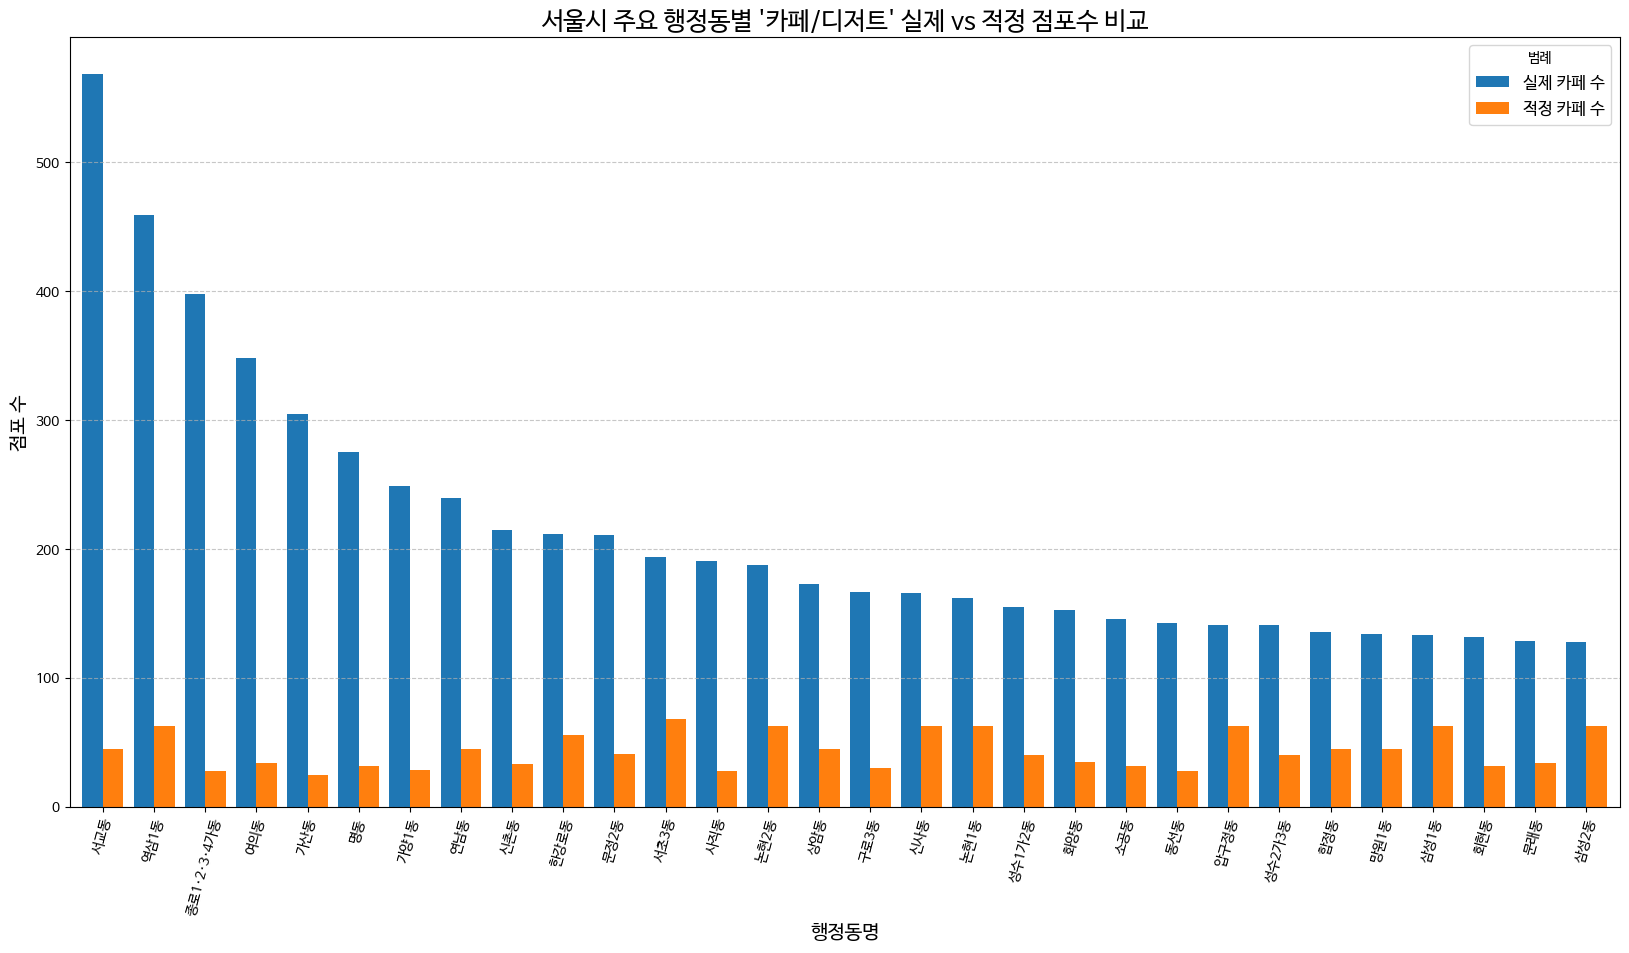

In [13]:
#
# 셀 7 (수정): 선형 회귀를 사용한 업종별 예측 및 시각화
#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. 업종별 예측 및 결과 종합
# 결과를 저장할 데이터프레임
df_report_linear = pd.DataFrame(index=df_final.index)
# 각 변수의 영향력(계수)을 저장할 데이터프레임
df_coeffs = pd.DataFrame(index=features)


print("--- 업종별 선형회귀 분석 시작 ---")
for category in target_categories:
    # 1-1. 데이터 준비
    X_input = X_scaled # 스케일링된 원본 변수 사용
    y_actual = df_final[category]
    y_log = df_final_log[f'로그_{category}']

    # 1-2. 선형 회귀 모델 학습
    linear_model = LinearRegression()
    linear_model.fit(X_input, y_log)

    # 1-3. 예측 및 원래 값으로 복원
    log_predictions = linear_model.predict(X_input)
    predictions = np.expm1(log_predictions).astype(int)

    # 1-4. 모델 설명력(R²) 계산 및 출력
    r2 = r2_score(y_actual, predictions)
    print(f"  -> [{category}] 모델 설명력(R²): {r2:.2%}")

    # 1-5. 결과 저장
    df_report_linear[f'{category}_실제'] = y_actual
    df_report_linear[f'{category}_적정'] = predictions
    df_coeffs[f'{category}_영향력'] = linear_model.coef_ # 각 변수의 영향력(계수) 저장

print("\n--- ✅ 업종별 분석 및 최종 요약 테이블 완성 ---")
display(df_report_linear.head())

# 2. 업종별 변수 영향력 확인
print("\n--- 업종별 핵심 요인 영향력(계수) 비교 ---")
print("(양수일수록 점포 수 증가에, 음수일수록 감소에 영향을 줌)")
display(df_coeffs.style.background_gradient(cmap='coolwarm', axis=0))


# 3. '카페/디저트' 업종 상세 분석 시각화
print("\n--- '카페/디저트' 업종 상세 분석 시각화 ---")
target_category_to_view = '카페/디저트'
if f'{target_category_to_view}_실제' in df_report_linear.columns:
    actual_col = f'{target_category_to_view}_실제'
    optimal_col = f'{target_category_to_view}_적정'
    df_view = df_report_linear[[actual_col, optimal_col]].copy()
    df_view.rename(columns={actual_col: '실제 카페 수', optimal_col: '적정 카페 수'}, inplace=True)

    df_view_top30 = df_view.sort_values(by='실제 카페 수', ascending=False).head(30)

    df_view_top30.plot(kind='bar', figsize=(20, 10), width=0.8)
    plt.title(f"서울시 주요 행정동별 '{target_category_to_view}' 실제 vs 적정 점포수 비교", fontsize=18)
    plt.ylabel('점포 수', fontsize=14)
    plt.xlabel('행정동명', fontsize=14)
    plt.xticks(rotation=75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='범례', fontsize=12)
    plt.show()
else:
    print(f"'{target_category_to_view}' 업종이 데이터에 없어 시각화할 수 없습니다.")

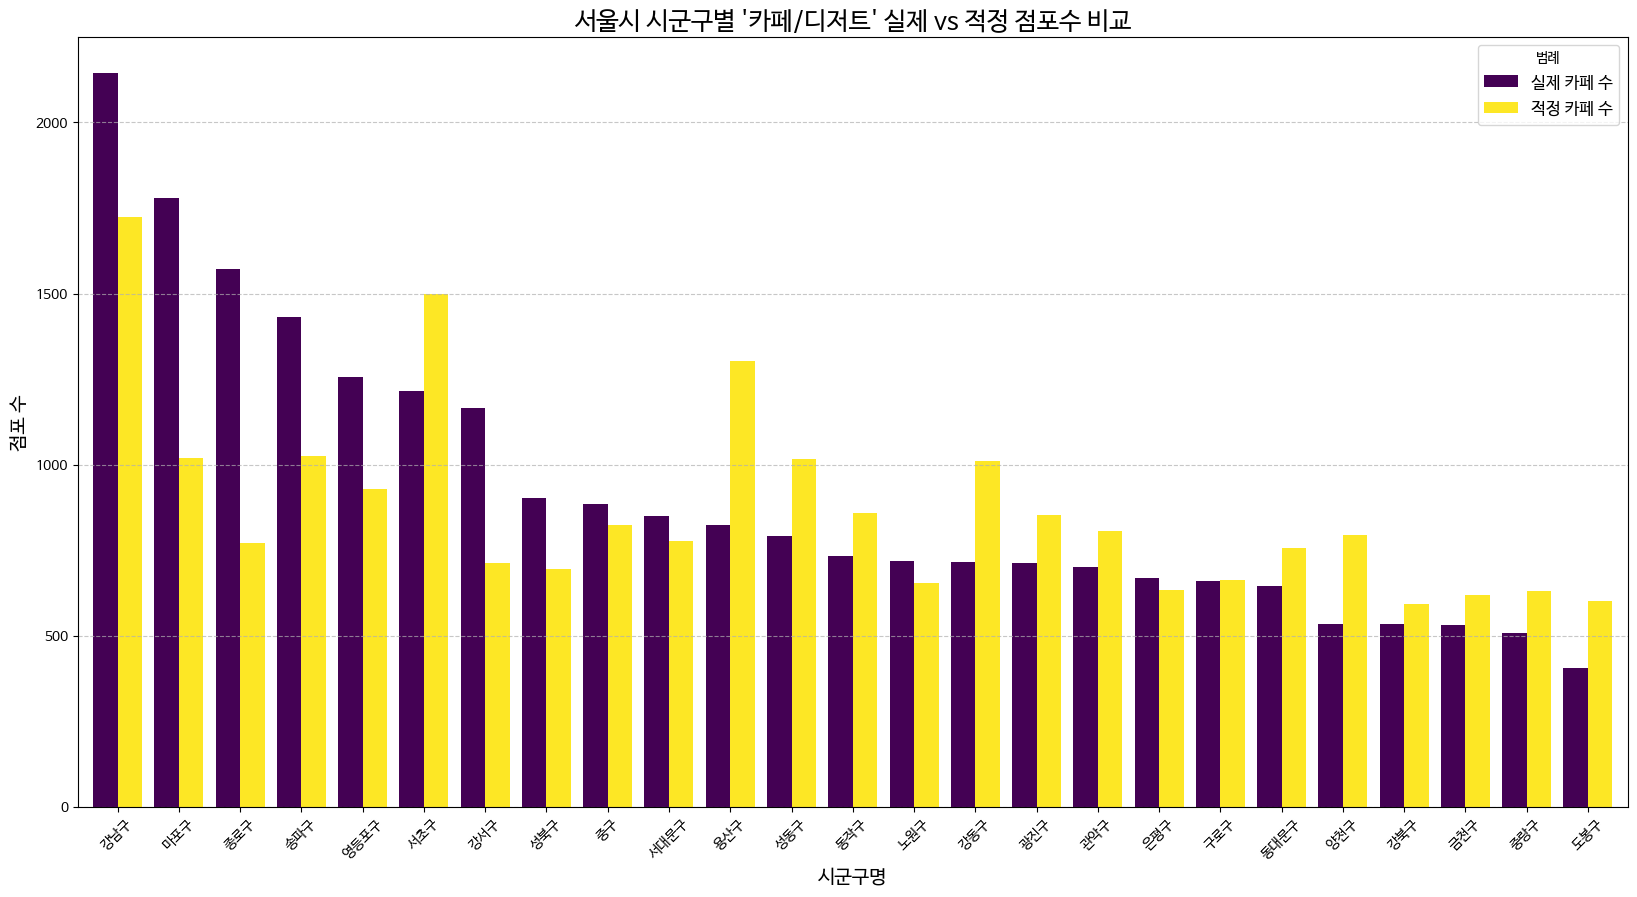

--- '카페/디저트' 성장 잠재력 지역 TOP 5 ---


,카페/디저트_실제,카페/디저트_적정,카페/디저트_포화도,한식_실제,한식_적정,한식_포화도,생활편의_실제,생활편의_적정,생활편의_포화도,쇼핑_실제,쇼핑_적정,쇼핑_포화도,주점/바_실제,주점/바_적정,주점/바_포화도
시군구명,,,,,,,,,,,,,,,
용산구,823,1304,-481,1401,2424,-1023,683,1414,-731,2978,4608,-1630,648,741,-93
강동구,714,1010,-296,1803,2331,-528,1574,1816,-242,3124,3472,-348,624,894,-270
서초구,1214,1500,-286,2305,2612,-307,1478,1473,5,5373,5166,207,557,780,-223
양천구,535,795,-260,1231,1825,-594,1129,1139,-10,2142,3133,-991,391,581,-190
성동구,792,1016,-224,1674,2117,-443,997,1300,-303,2320,3772,-1452,502,670,-168


In [17]:
#
# 셀 8 (수정): '카페/디저트' 업종 상세 분석 및 시각화 (Bar Plot)
#

# 1. 시각화할 데이터 선택
target_category_to_view = '카페/디저트'
actual_col = f'{target_category_to_view}_실제'
optimal_col = f'{target_category_to_view}_적정'
df_view = df_report_linear[[actual_col, optimal_col]].copy()
df_view.rename(columns={actual_col: '실제 카페 수', optimal_col: '적정 카페 수'}, inplace=True)

# 2. 실제 점포수가 많은 순으로 정렬
df_view = df_view.sort_values(by='실제 카페 수', ascending=False)

# 3. Bar Plot 시각화
df_view.plot(kind='bar', figsize=(20, 10), width=0.8, colormap='viridis')
plt.title(f"서울시 시군구별 '{target_category_to_view}' 실제 vs 적정 점포수 비교", fontsize=18)
plt.ylabel('점포 수', fontsize=14)
plt.xlabel('시군구명', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='범례', fontsize=12)
plt.show()

# 4. 포화도 지수가 낮은(성장 잠재력 높은) 지역 확인
print(f"--- '{target_category_to_view}' 성장 잠재력 지역 TOP 5 ---")
display(df_report_linear.sort_values(by=f'{target_category_to_view}_포화도').head())